In [136]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import re
from os import listdir
from os.path import isfile, join
import json

onlyfiles = [
    f for f in listdir("./test-flight-user-daily") if isfile(join("./test-flight-user-daily", f))
]


print(len(onlyfiles))
onlyfiles[:5]

475


['csv-2021-04-17-07-26-25-none-1035-iPhone10-0-27.53-44.36-null-NMSnore-NAvgSnore-27.40.csv',
 'csv-2021-04-17-11-39-25-none-1035-iPhone10-0-25.66-27.45-null-NMSnore-NAvgSnore-25.66.csv',
 'csv-2021-04-17-08-12-25-none-1035-iPhone10-0-23.55-26.73-null-NMSnore-NAvgSnore-23.55.csv',
 'csv-2021-04-17-10-42-25-none-1035-iPhone10-0-25.44-30.38-null-NMSnore-NAvgSnore-25.44.csv',
 'csv-2021-04-17-10-50-25-snore-1035-iPhone10-8-32.32-44.90-10-49-45.583-43.49-39.36-30.78.csv']

In [137]:
def parse_file_name(file_name):
    pattern = r"csv-(\d{4}-\d{2}-\d{2})-(\d{2}-\d{2}-\d{2})-(\w+)-(\d+)-iPhone\d+-(\d+)-(\d+\.\d+)-(\d+\.\d+)-(\d{2}-\d{2}-\d+\.\d+|null)-(NMSnore|\d+\.\d+)-(NAvgSnore|\d+\.\d+)-(\d+\.\d+|\-inf).csv"
    match = re.match(pattern, file_name)
    if match:
        return {
            "date": match.group(1),
            "time": match.group(2),
            "event_type": match.group(3),
            "version": int(match.group(4)),
            "snore_count": int(match.group(5)),
            "avg_db": float(match.group(6)),
            "max_db": float(match.group(7)),
            "start_snore_event_timestamp": match.group(8),
            "max_snore_db": match.group(9),
            "avg_snore_db": match.group(10),
            "noise_level": match.group(11),
        }
    else:
        print(file_name)
        raise Exception("Not possible")


parsed_data = [
    parse_file_name(fn) for fn in onlyfiles if parse_file_name(fn) is not None
]

df = pd.DataFrame(parsed_data)
df["datetime"] = df.apply(
    lambda row: datetime.strptime(f"{row['date']} {row['time']}", "%Y-%m-%d %H-%M-%S"),
    axis=1,
)
df = df.drop(["date", "time"], axis=1)

df = df.sort_values(by="datetime")

df_hour = df.copy()

df_hour["hour"] = df["datetime"].dt.hour


df.reset_index(inplace=True)
df = df.drop(columns=["index"])
df.describe()

,version,snore_count,avg_db,max_db,datetime
count,475.0,475.000000,475.000000,475.000000,475
mean,1035.0,1.827368,28.673053,43.379284,2021-04-17 08:32:13.465263360
min,1035.0,0.000000,22.880000,24.030000,2021-04-17 03:04:06
25%,1035.0,0.000000,25.600000,33.645000,2021-04-17 06:33:55
50%,1035.0,0.000000,27.420000,43.000000,2021-04-17 08:32:25
75%,1035.0,2.000000,30.610000,52.265000,2021-04-17 10:30:55
max,1035.0,15.000000,46.200000,76.520000,2021-04-17 12:29:25
std,0.0,3.423006,4.365720,11.173085,NaN


In [138]:
df = df[df["event_type"] == "snore"]
df["max_snore_db"] = df["max_snore_db"].astype(float)
df["avg_snore_db"] = df["avg_snore_db"].astype(float)
df["noise_level"] = df["noise_level"].astype(float)
df.dtypes

event_type                             object
version                                 int64
snore_count                             int64
avg_db                                float64
max_db                                float64
start_snore_event_timestamp            object
max_snore_db                          float64
avg_snore_db                          float64
noise_level                           float64
datetime                       datetime64[ns]
dtype: object

In [139]:
def apply_increase_level(noise_level, avg_snore_db):
    percentage_increase = ((avg_snore_db - noise_level) / noise_level) * 100
    return percentage_increase


df["noise_increase_percentage"] = df.apply(
    lambda row: apply_increase_level(row["noise_level"], row["avg_snore_db"]), axis=1
)

df.head(15)

,event_type,version,snore_count,avg_db,max_db,start_snore_event_timestamp,max_snore_db,avg_snore_db,noise_level,datetime,noise_increase_percentage
1,snore,1035,1,34.91,76.52,03-04-09.234,44.71,44.71,32.75,2021-04-17 04:36:25,36.519084
2,snore,1035,3,35.79,54.49,04-36-28.794,53.43,49.58,32.28,2021-04-17 04:37:25,53.593556
6,snore,1035,1,27.93,42.19,04-41-13.170,37.05,37.05,27.51,2021-04-17 04:41:25,34.678299
7,snore,1035,5,29.83,42.98,04-41-27.666,42.44,41.05,28.89,2021-04-17 04:42:25,42.090689
9,snore,1035,4,29.41,47.34,04-43-30.793,46.67,40.56,28.34,2021-04-17 04:44:25,43.119266
10,snore,1035,7,29.14,50.21,04-44-29.044,50.21,43.21,26.60,2021-04-17 04:45:25,62.443609
11,snore,1035,6,29.48,51.83,04-45-28.418,50.27,45.00,28.10,2021-04-17 04:46:25,60.142349
12,snore,1035,14,33.17,52.57,04-46-29.291,51.03,45.13,29.33,2021-04-17 04:47:25,53.869758
18,snore,1035,1,25.74,35.48,04-52-55.042,31.30,31.30,25.56,2021-04-17 04:53:25,22.456964
20,snore,1035,1,27.33,57.56,04-55-20.541,44.39,44.39,25.51,2021-04-17 04:55:25,74.010192


In [140]:
df["datetime"] = pd.to_datetime(df["datetime"])

thresholds = {"Quiet": 10, "Light": 20, "Loud": 30, "Severe": 100}


def categorize_noise_level(row):
    for category, threshold in thresholds.items():
        if row["noise_increase_percentage"] < threshold:
            return category
    return "Quiet"


df["category"] = df.apply(categorize_noise_level, axis=1)

grouped = df.groupby([pd.Grouper(key="datetime", freq="15T"), "category"])

grouped_daily = df.groupby([pd.Grouper(key="datetime", freq="D"), "category"])

# grouped.head()
counts = grouped.size().reset_index(name="counts")
counts_daily = grouped_daily.size().reset_index(name="counts")

# counts
pivot_table = counts.pivot(
    index="datetime", columns="category", values="counts"
).fillna(0)

pivot_table_daily = counts_daily.pivot(
    index="datetime", columns="category", values="counts"
).fillna(0)

pivot_table

category,Light,Loud,Quiet,Severe
datetime,,,,
2021-04-17 04:30:00,0.0,0.0,0.0,5.0
2021-04-17 04:45:00,0.0,1.0,0.0,8.0
2021-04-17 05:00:00,0.0,0.0,0.0,8.0
2021-04-17 05:15:00,3.0,2.0,0.0,8.0
2021-04-17 05:30:00,1.0,0.0,1.0,8.0
2021-04-17 05:45:00,0.0,0.0,0.0,8.0
2021-04-17 06:00:00,0.0,2.0,0.0,4.0
2021-04-17 06:15:00,0.0,2.0,0.0,11.0
2021-04-17 06:30:00,0.0,0.0,0.0,4.0


In [141]:

pivot_table_daily

category,Light,Loud,Quiet,Severe
datetime,,,,
2021-04-17,7,12,2,147


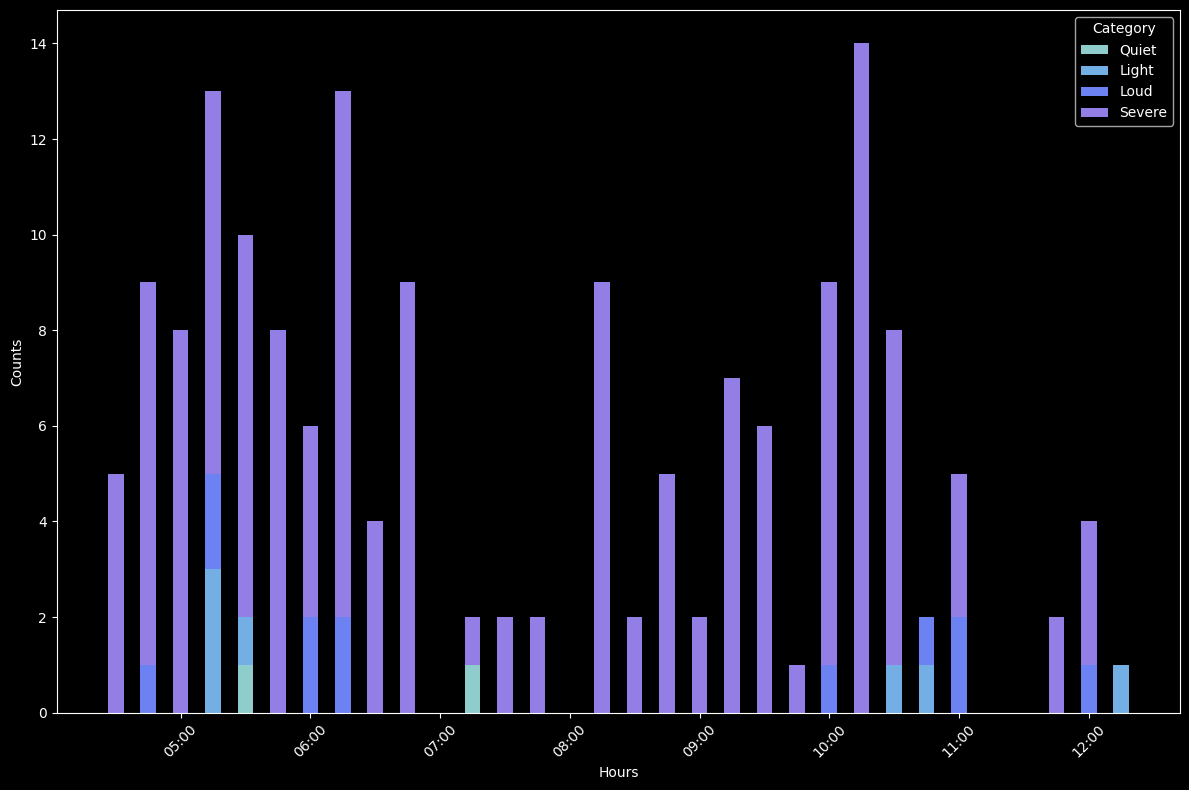

In [142]:
import matplotlib.dates as mdates


plt.style.use('dark_background')
plt.figure(figsize=(12, 8))


colors = {
    "Quiet": "#8fcccc",
    "Light": "#73aee5",
    "Loud": "#6d82f2",
    "Severe": "#937ee5",
}


bottom = None
for category, color in colors.items():
    plt.bar(
        pivot_table.index,
        pivot_table.get(category, 0),
        bottom=bottom,
        color=color,
        label=category,
        width=0.005,
    )
    if bottom is None:
        bottom = pivot_table.get(category, 0)
    else:
        bottom += pivot_table.get(category, 0)



plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xlabel("Hours")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.legend(title="Category")


plt.tight_layout()
plt.show()

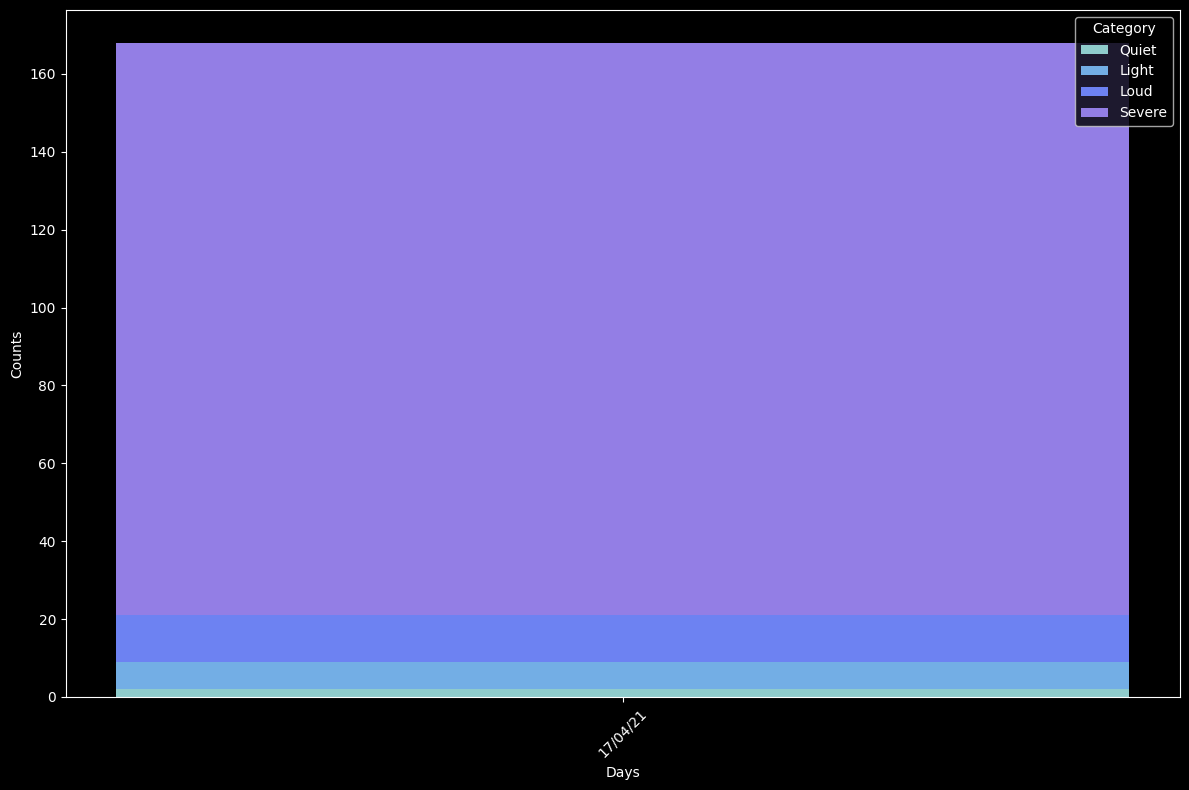

In [143]:
import matplotlib.dates as mdates


plt.style.use('dark_background')
plt.figure(figsize=(12, 8))


colors = {
    "Quiet": "#8fcccc",
    "Light": "#73aee5",
    "Loud": "#6d82f2",
    "Severe": "#937ee5",
}


bottom = None
for category, color in colors.items():
    plt.bar(
        pivot_table_daily.index,
        pivot_table_daily.get(category, 0),
        bottom=bottom,
        color=color,
        label=category,
        width=0.5,
    )
    if bottom is None:
        bottom = pivot_table_daily.get(category, 0)
    else:
        bottom += pivot_table_daily.get(category, 0)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
plt.xticks(pivot_table_daily.index)

plt.xlabel("Days")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.legend(title="Category")


plt.tight_layout()
plt.show()

In [144]:
pivot_table_reset_index = pivot_table.reset_index()


api_json_object = json.loads(
    pivot_table_reset_index.to_json(orient="records", date_format="iso")
)


# with open("dump_graph.json", 'w') as f:
#     json.dump(api_json_object, f, indent=4)

# f.close()

api_json_object[:5]

[{'datetime': '2021-04-17T04:30:00.000',
  'Light': 0.0,
  'Loud': 0.0,
  'Quiet': 5.0,
  'Severe': 5.0},
 {'datetime': '2021-04-17T04:45:00.000',
  'Light': 0.0,
  'Loud': 1.0,
  'Quiet': 9.0,
  'Severe': 8.0},
 {'datetime': '2021-04-17T05:00:00.000',
  'Light': 0.0,
  'Loud': 0.0,
  'Quiet': 8.0,
  'Severe': 8.0},
 {'datetime': '2021-04-17T05:15:00.000',
  'Light': 3.0,
  'Loud': 2.0,
  'Quiet': 13.0,
  'Severe': 8.0},
 {'datetime': '2021-04-17T05:30:00.000',
  'Light': 1.0,
  'Loud': 0.0,
  'Quiet': 10.0,
  'Severe': 8.0}]